<a href="https://colab.research.google.com/github/FtmMoradian/Brain-tumor-Diagnosis-with-AI/blob/main/Brain_Tumor_Classifacation_with_Augmentation_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Augmentation Image

Import Libraries

In [ ]:
from PIL import Image
from PIL import ImageFilter
!pip install --upgrade pip
!pip install imutils
import numpy as np
import pandas as pd
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import cv2
%matplotlib inline
import imutils
import cv2
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
plt.style.use('dark_background')
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


File Location

In [ ]:
image_dir="/content/drive/MyDrive/Brain_Tumor_Classification /Data Set/"
os.makedirs('/content/drive/MyDrive/Brain_Tumor_Classification /output')
os.makedirs('/content/drive/MyDrive/Brain_Tumor_Classification /output/yes')
os.makedirs('/content/drive/MyDrive/Brain_Tumor_Classification /output/no')

Augmentation of images

In [ ]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)

        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0

        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break


augmented_data_path ='/content/drive/MyDrive/Brain_Tumor_Classification /output/'
augment_data(file_dir=image_dir+'yes',n_generated_samples=7, save_to_dir=augmented_data_path+'yes')
augment_data(file_dir=image_dir+'no', n_generated_samples=10, save_to_dir=augmented_data_path+'no')

Preprocessing the data

In [ ]:
import PIL
def crop_brain_contour(image, plot=False):
    intact=image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray,5)
    thresh = cv2.threshold(gray, 46, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    image = new_image



    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(intact)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped-Image')
        plt.show()

    return image

After applying the cropping function

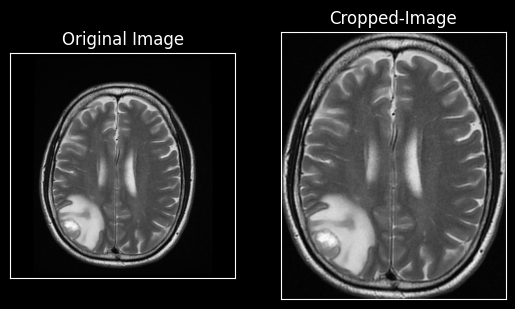

In [ ]:
ex_crop_img = crop_brain_contour( cv2.imread(image_dir+'yes/Y107.jpg'), True)

# SVM Model for Augmentation of images

In [ ]:
data = []
category = []

Preprocessing Data

In [ ]:
for filename in os.scandir("/content/drive/MyDrive/Brain_Tumor_Classification /output/no"):
    if filename.is_file():
        img = Image.open(filename.path)
        img = img.resize(size=(32,32))
        img = img.convert('L')
        data.append(np.array(img).flatten())
        category.append(0)
        del img

In [ ]:
for filename in os.scandir("/content/drive/MyDrive/Brain_Tumor_Classification /output/yes"):
    if filename.is_file():
        img = Image.open(filename.path)
        img = img.resize(size=(32,32))
        img = img.convert('L')
        data.append(np.array(img).flatten())
        category.append(1)
        del img

In [ ]:
x,y = np.array(data),category

In [ ]:
x.shape

(2069, 1024)

In [ ]:
len(y)

2069

Split Train and Test Model

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=1)

Train Model

In [ ]:
svm_model = SVC(kernel='linear',C = 0.1,random_state=0)

In [ ]:
svm_model.fit(x_train,y_train)

SVC(C=0.1, kernel='linear', random_state=0)

Accuracy

In [ ]:
print("The score is :",svm_model.score(x_train,y_train)*100,"%")

The score is : 100.0 %


In [ ]:
print("The score is :",svm_model.score(x_test,y_test)*100,"%")

The score is : 67.31078904991948 %


# Logistic Regression Model for Augmentation of images

In [ ]:
data = []
category = []

Preprocess

In [ ]:
for filename in os.scandir("/content/drive/MyDrive/Brain_Tumor_Classification /output/no"):
    if filename.is_file():
        img = Image.open(filename.path)
        img = img.resize(size=(32,32))
        img = img.convert('L')
        data.append(np.array(img).flatten())
        category.append(0)
        del img

In [ ]:
for filename in os.scandir("/content/drive/MyDrive/Brain_Tumor_Classification /output/yes"):
    if filename.is_file():
        img = Image.open(filename.path)
        img = img.resize(size=(32,32))
        img = img.convert('L')
        data.append(np.array(img).flatten())
        category.append(1)
        del img

In [ ]:
x,y = np.array(data),category

In [ ]:
x.shape

(2069, 1024)

In [ ]:
len(y)

2069

Split Train and Test Model

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=1)

Train Model

In [ ]:
lg = LogisticRegression()

In [ ]:
lg.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Accuracy

In [ ]:
print("The score for Train Model is :",lg.score(x_train,y_train)*100,"%")

The score for Train Model is : 93.57734806629834 %


In [ ]:
print("The score for Test Model is :",lg.score(x_test,y_test)*100,"%")

The score for Test Model is : 67.14975845410628 %


# KNN Model for Augmentation of images

In [ ]:
Kdata = []
Kcategory = []

Preprocess

In [ ]:
for filename in os.scandir("/content/drive/MyDrive/Brain_Tumor_Classification /output/no"):
    if filename.is_file():
        img = Image.open(filename.path)
        img = img.resize(size=(32,32))
        img = img.convert('L')
        Kdata.append(np.array(img).flatten())
        Kcategory.append(0)
        del img

In [ ]:
for filename in os.scandir("/content/drive/MyDrive/Brain_Tumor_Classification /output/yes"):
    if filename.is_file():
        img = Image.open(filename.path)
        img = img.resize(size=(32,32))
        img = img.convert('L')
        Kdata.append(np.array(img).flatten())
        Kcategory.append(1)
        del img

In [ ]:
x,y = np.array(Kdata),Kcategory

In [ ]:
x.shape

(3026, 1024)

In [ ]:
len(y)

3026

Split Train and Test Model

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=1)

Train Model

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=3,weights="uniform",algorithm="auto")

In [ ]:
knn_model.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=3)

Accuracy

In [ ]:
print("The score is:",knn_model.score(x_train,y_train)*100,"%")

The score is: 90.84041548630783 %


In [ ]:
print("The score is:",knn_model.score(x_test,y_test)*100,"%")

The score is: 83.59030837004406 %


# CNN Model for Augmentation of images

In [ ]:
encoder = OneHotEncoder()
encoder.fit([[0], [1]])

# 0 - Normal
# 1 - Tumor

OneHotEncoder()

Preprocess

In [ ]:
data = []
paths = []
result = []

for r, d, f in os.walk(r'/content/drive/MyDrive/Brain_Tumor_Classification /output/no'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())

In [ ]:
paths = []
for r, d, f in os.walk(r"/content/drive/MyDrive/Brain_Tumor_Classification /output/yes"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())

In [ ]:
data = np.array(data)
data.shape

(2067, 128, 128, 3)

In [ ]:
result = np.array(result)
result = result.reshape(2067,2)

Split Train and Test Model

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(data, result, test_size=0.2, shuffle=True, random_state=0)

Train Model

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding = 'Same'))
model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))


model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss = "categorical_crossentropy", optimizer='Adamax')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      416       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4128      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        8

In [ ]:
y_train.shape

(1653, 2)

In [ ]:
history = model.fit(x_train, y_train, epochs = 30, batch_size = 40, verbose = 1,validation_data = (x_test, y_test))

Epoch 1/30
42/42 [==============================] - 161s 4s/step - loss: 9.8650 - val_loss: 0.8668
Epoch 2/30
42/42 [==============================] - 146s 3s/step - loss: 0.7729 - val_loss: 0.4938
Epoch 3/30
42/42 [==============================] - 147s 4s/step - loss: 0.3865 - val_loss: 0.4770
Epoch 4/30
42/42 [==============================] - 148s 4s/step - loss: 0.2783 - val_loss: 0.4178
Epoch 5/30
42/42 [==============================] - 147s 4s/step - loss: 0.2038 - val_loss: 0.5079
Epoch 6/30
42/42 [==============================] - 146s 4s/step - loss: 0.1651 - val_loss: 0.4907
Epoch 7/30
42/42 [==============================] - 148s 4s/step - loss: 0.1560 - val_loss: 0.5558
Epoch 8/30
42/42 [==============================] - 145s 3s/step - loss: 0.1325 - val_loss: 0.6070
Epoch 9/30
42/42 [==============================] - 144s 3s/step - loss: 0.1011 - val_loss: 0.6516
Epoch 10/30
42/42 [==============================] - 146s 3s/step - loss: 0.0749 - val_loss: 0.7191
Epoch 11/

Plotting Data

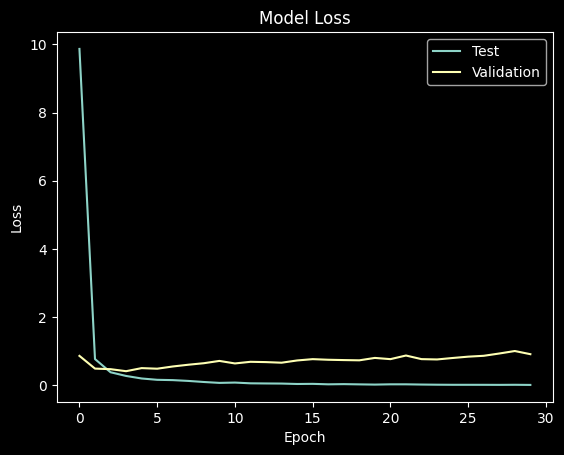

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.show()

Accuracy by Visualizing

In [ ]:
def names(number):
    if number==1:
        return 'Its a Tumor'
    else:
        return 'No, Its not a tumor'

100.0% Confidence No, Its not a tumor


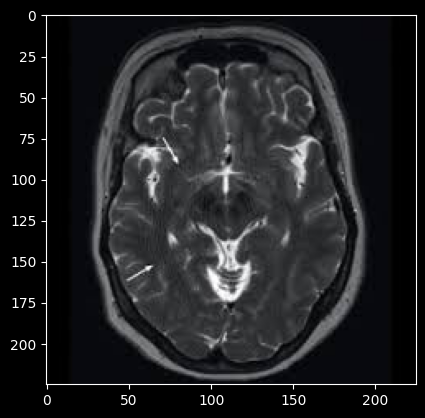

In [ ]:
from matplotlib.pyplot import imshow
img = Image.open(r"/content/drive/MyDrive/Brain_Tumor_Classification /input/3 no.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence ' + names(classification))

99.99957084655762% Confidence Its a Tumor


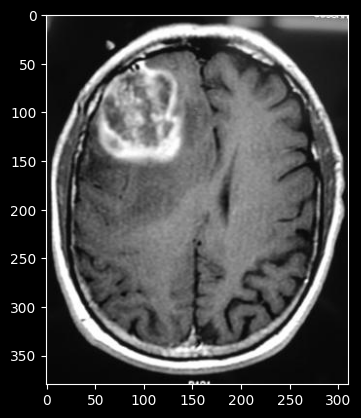

In [ ]:
from matplotlib.pyplot import imshow
img = Image.open(r"/content/drive/MyDrive/Brain_Tumor_Classification /Data Set/yes/Y15.jpg")
x = np.array(img.resize((128,128)))
x = x.reshape(1,128,128,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence ' + names(classification))